In [1]:
# Install Required Packages
!pip install gymnasium[atari] -q
!pip install gymnasium[accept-rom-license] -q
!pip install ale-py -q
!pip install torch torchvision -q
!pip install opencv-python -q
!pip install matplotlib -q

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Test Environment and GPU
import gymnasium as gym
import torch
import numpy as np
import ale_py

# Register Atari environments
gym.register_envs(ale_py)

# Check GPU availability
print("=" * 50)
print("SYSTEM CHECK")
print("=" * 50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print()

# Test Bank Heist environment
print("=" * 50)
print("TESTING BANK HEIST ENVIRONMENT")
print("=" * 50)

env = gym.make('ALE/BankHeist-v5', render_mode='rgb_array')
state, info = env.reset()

print(f"Environment created successfully!")
print(f"State shape (frame dimensions): {state.shape}")
print(f"Number of possible actions: {env.action_space.n}")
print(f"Actions available: {env.unwrapped.get_action_meanings()}")

# Take a test action
action = env.action_space.sample()
next_state, reward, terminated, truncated, info = env.step(action)
print(f"Test action completed - Reward: {reward}")

env.close()
print()
print("All tests passed! Ready to build the agent!")
print("=" * 50)

SYSTEM CHECK
Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.83 GB

TESTING BANK HEIST ENVIRONMENT
Environment created successfully!
State shape (frame dimensions): (210, 160, 3)
Number of possible actions: 18
Actions available: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
Test action completed - Reward: 0.0

All tests passed! Ready to build the agent!


In [3]:
# CELL 3: Build the Deep Q-Network
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """
    Deep Q-Network for Bank Heist
    Takes 4 stacked grayscale frames (84x84) as input
    Outputs Q-values for each of the 18 possible actions
    """
    def __init__(self, action_size):
        super(DQN, self).__init__()

        # Convolutional layers to process game frames
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # 4 frames -> 32 features
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # 32 -> 64 features
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # 64 -> 64 features

        # Fully connected layers for decision making
        self.fc1 = nn.Linear(7 * 7 * 64, 512)  # Flatten and connect
        self.fc2 = nn.Linear(512, action_size)  # Output Q-value for each action

    def forward(self, x):
        """Process frames through the network"""
        x = F.relu(self.conv1(x))  # Learn features from frames
        x = F.relu(self.conv2(x))  # Learn higher-level features
        x = F.relu(self.conv3(x))  # Learn even higher-level features

        x = x.view(x.size(0), -1)  # Flatten for fully connected layers

        x = F.relu(self.fc1(x))    # Decision making layer
        x = self.fc2(x)            # Q-values for each action

        return x

# Test the network
print("Testing Deep Q-Network...")
test_dqn = DQN(action_size=18)
test_input = torch.randn(1, 4, 84, 84)  # Batch of 1, 4 frames, 84x84 pixels
test_output = test_dqn(test_input)

print(f"Network created successfully!")
print(f"Input shape: {test_input.shape} (1 sample, 4 frames, 84x84 pixels)")
print(f"Output shape: {test_output.shape} (1 sample, 18 Q-values)")
print(f"Sample Q-values: {test_output[0][:5].detach().numpy()}")
print("Neural network is ready!")

Testing Deep Q-Network...
Network created successfully!
Input shape: torch.Size([1, 4, 84, 84]) (1 sample, 4 frames, 84x84 pixels)
Output shape: torch.Size([1, 18]) (1 sample, 18 Q-values)
Sample Q-values: [-0.00414363 -0.01629326  0.09182277 -0.01050429 -0.00245227]
Neural network is ready!


In [4]:
# Frame Preprocessor
import cv2
from collections import deque

class FramePreprocessor:
    """
    Preprocesses game frames for the DQN:
    - Converts RGB to grayscale
    - Resizes to 84x84
    - Normalizes pixel values
    - Stacks 4 frames together (gives agent sense of motion)
    """
    def __init__(self, frame_stack_size=4):
        self.frame_stack_size = frame_stack_size
        self.frames = deque(maxlen=frame_stack_size)

    def preprocess_frame(self, frame):
        """Convert a single frame to grayscale, resize, and normalize"""
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        normalized = resized / 255.0  # Scale to 0-1 range
        return normalized

    def reset(self, initial_frame):
        """Initialize frame stack at episode start"""
        processed = self.preprocess_frame(initial_frame)
        self.frames.clear()
        # Fill with 4 copies of the first frame
        for _ in range(self.frame_stack_size):
            self.frames.append(processed)
        return np.stack(self.frames, axis=0)

    def add_frame(self, frame):
        """Add a new frame to the stack"""
        processed = self.preprocess_frame(frame)
        self.frames.append(processed)
        return np.stack(self.frames, axis=0)

# Test the preprocessor
print("Testing Frame Preprocessor...")
env = gym.make('ALE/BankHeist-v5', render_mode='rgb_array')
state, _ = env.reset()

preprocessor = FramePreprocessor()
processed_state = preprocessor.reset(state)

print(f"Original frame shape: {state.shape}")
print(f"Processed state shape: {processed_state.shape}")
print(f"Pixel value range: [{processed_state.min():.3f}, {processed_state.max():.3f}]")
print("Frame preprocessor is ready!")

env.close()

Testing Frame Preprocessor...
Original frame shape: (210, 160, 3)
Processed state shape: (4, 84, 84)
Pixel value range: [0.000, 0.580]
Frame preprocessor is ready!


In [5]:
# Replay Memory
import random
from collections import deque

class ReplayMemory:
    """
    Experience Replay Buffer for DQN
    Stores transitions (state, action, reward, next_state, done)
    Samples random batches to break temporal correlation
    """
    def __init__(self, capacity=50000):
        """
        Args:
            capacity: Maximum number of experiences to store
        """
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """Store a transition in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample a random batch of experiences

        Returns:
            Tuple of numpy arrays: (states, actions, rewards, next_states, dones)
        """
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def __len__(self):
        """Return current size of memory"""
        return len(self.memory)

# Test the replay memory
print("Testing Replay Memory...")
memory = ReplayMemory(capacity=50000)

# Add some dummy experiences
for i in range(100):
    dummy_state = np.random.rand(4, 84, 84)
    dummy_action = np.random.randint(0, 18)
    dummy_reward = np.random.rand()
    dummy_next_state = np.random.rand(4, 84, 84)
    dummy_done = False

    memory.push(dummy_state, dummy_action, dummy_reward, dummy_next_state, dummy_done)

print(f"Memory size: {len(memory)}")
print(f"Memory capacity: 50000")

# Sample a batch
states, actions, rewards, next_states, dones = memory.sample(32)
print(f"Sampled batch - States shape: {states.shape}")
print(f"Sampled batch - Actions shape: {actions.shape}")
print(f"Sampled batch - Rewards shape: {rewards.shape}")
print("Replay memory is ready!")

Testing Replay Memory...
Memory size: 100
Memory capacity: 50000
Sampled batch - States shape: (32, 4, 84, 84)
Sampled batch - Actions shape: (32,)
Sampled batch - Rewards shape: (32,)
Replay memory is ready!


In [6]:
# DQN Agent
import torch.optim as optim

class DQNAgent:
    """
    Deep Q-Network Agent for Bank Heist
    Implements Double DQN algorithm with experience replay and target network
    """
    def __init__(self, state_shape, action_size, learning_rate=0.00025,
                 gamma=0.99, epsilon_start=1.0, epsilon_min=0.01,
                 epsilon_decay=0.995, memory_size=50000):
        """
        Args:
            state_shape: Shape of input state (4, 84, 84)
            action_size: Number of possible actions (18 for Bank Heist)
            learning_rate: Learning rate for optimizer (alpha in Bellman equation)
            gamma: Discount factor for future rewards
            epsilon_start: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Rate at which epsilon decreases
            memory_size: Capacity of replay buffer
        """
        self.state_shape = state_shape
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate

        # Set device (GPU if available)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Agent using device: {self.device}")

        # Create policy network (the one we train)
        self.policy_net = DQN(action_size).to(self.device)

        # Create target network (stabilizes training)
        self.target_net = DQN(action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set to evaluation mode

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

        # Replay memory
        self.memory = ReplayMemory(memory_size)

    def select_action(self, state, training=True):
        """
        Select action using epsilon-greedy policy

        Args:
            state: Current game state
            training: If True, use epsilon-greedy; if False, use greedy

        Returns:
            Selected action (integer)
        """
        # Exploration: random action
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)

        # Exploitation: best action according to Q-network
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def train_step(self, batch_size=32):
        """
        Perform one training step using a batch from replay memory
        DOUBLE DQN: Uses policy network to SELECT actions, target network to EVALUATE
        This reduces Q-value overestimation bias

        Args:
            batch_size: Number of experiences to sample

        Returns:
            Loss value for this training step
        """
        # Need enough experiences in memory
        if len(self.memory) < batch_size:
            return None

        # Sample batch from memory
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Current Q values: Q(s, a)
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))

        # ===== DOUBLE DQN MODIFICATION =====
        # Standard DQN uses: next_q_values = self.target_net(next_states).max(1)[0]
        # Double DQN separates action selection from action evaluation

        with torch.no_grad():
            # Step 1: Use POLICY network to SELECT the best action for next state
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)

            # Step 2: Use TARGET network to EVALUATE that selected action
            next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze()

            # Bellman equation: Q_target = r + gamma * Q_target(s', argmax_a Q_policy(s', a)) * (1 - done)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        # ===================================

        # Compute loss (Mean Squared Error)
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)

        # Optimize the network
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for training stability
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)

        self.optimizer.step()

        return loss.item()

    def update_target_network(self):
        """Copy weights from policy network to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        """Decrease exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']

# Test the agent
print("Testing Double DQN Agent...")
test_agent = DQNAgent(state_shape=(4, 84, 84), action_size=18)
test_state = np.random.rand(4, 84, 84)
test_action = test_agent.select_action(test_state)
print(f"Agent selected action: {test_action}")
print(f"Initial epsilon: {test_agent.epsilon}")
print("Double DQN Agent is ready!")

Testing Double DQN Agent...
Agent using device: cuda
Agent selected action: 11
Initial epsilon: 1.0
Double DQN Agent is ready!


In [7]:
  # Mount Google Drive and Setup Paths
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create directory in your Google Drive
drive_base_path = '/content/drive/MyDrive/BankHeist_DQN_Project'
os.makedirs(drive_base_path, exist_ok=True)

print(f"Google Drive mounted successfully!")
print(f"Project directory: {drive_base_path}")
print(f"All checkpoints, models, and metrics will be saved here")
print("-" * 70)

Mounted at /content/drive
Google Drive mounted successfully!
Project directory: /content/drive/MyDrive/BankHeist_DQN_Project
All checkpoints, models, and metrics will be saved here
----------------------------------------------------------------------


In [8]:
# CELL 9: Memory-Efficient Trainer with Local + Drive Backup
import time
import json
import sys
import gc
import shutil

class BankHeistTrainer:
    """Memory-efficient trainer with auto-recovery"""
    def __init__(self, save_dir='./bank_heist_checkpoints', drive_backup_dir=None):
        self.save_dir = save_dir
        self.drive_backup_dir = drive_backup_dir
        os.makedirs(save_dir, exist_ok=True)
        if drive_backup_dir:
            os.makedirs(drive_backup_dir, exist_ok=True)

        self.episode_rewards = []
        self.episode_steps = []
        self.episode_losses = []
        self.epsilon_history = []

    def train(self, agent=None, start_episode=0, total_episodes=500,
              max_steps=2000, batch_size=32, learning_rate=0.00025,
              gamma=0.99, epsilon_start=1.0, epsilon_min=0.01,
              epsilon_decay=0.995, memory_size=30000,  # REDUCED from 50000
              target_update_freq=10, print_freq=50,
              local_save_freq=50, drive_save_freq=200):
        """
        Args:
            local_save_freq: Save to local disk every N episodes (fast)
            drive_save_freq: Copy to Drive every N episodes (slow but safe)
        """

        env = gym.make('ALE/BankHeist-v5', render_mode='rgb_array')
        preprocessor = FramePreprocessor()

        if agent is None:
            agent = DQNAgent(
                state_shape=(4, 84, 84), action_size=18,
                learning_rate=learning_rate, gamma=gamma,
                epsilon_start=epsilon_start, epsilon_min=epsilon_min,
                epsilon_decay=epsilon_decay, memory_size=memory_size
            )
            print(f"New agent created | Memory: {memory_size}")
        else:
            print(f"Resuming from episode {start_episode}")

        start_time = time.time()

        for episode in range(start_episode, start_episode + total_episodes):
            state, _ = env.reset()
            state = preprocessor.reset(state)
            episode_reward = 0
            episode_loss = []

            for step in range(max_steps):
                action = agent.select_action(state, training=True)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state = preprocessor.add_frame(next_state)
                agent.memory.push(state, action, reward, next_state, done)

                loss = agent.train_step(batch_size)
                if loss is not None:
                    episode_loss.append(loss)

                episode_reward += reward
                state = next_state
                if done:
                    break

            if episode % target_update_freq == 0:
                agent.update_target_network()
            agent.decay_epsilon()

            self.episode_rewards.append(episode_reward)
            self.episode_steps.append(step + 1)
            self.episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
            self.epsilon_history.append(agent.epsilon)

            # FAST LOCAL SAVE (every 50 episodes)
            if (episode + 1) % local_save_freq == 0:
                self._save_local_checkpoint(agent, episode + 1)

            # SLOW DRIVE BACKUP (every 200 episodes)
            if self.drive_backup_dir and (episode + 1) % drive_save_freq == 0:
                self._backup_to_drive()
                print(f"  Backed up to Drive at episode {episode + 1}")
                sys.stdout.flush()

            # Print progress
            if (episode + 1) % print_freq == 0:
                avg_reward = np.mean(self.episode_rewards[-min(100, len(self.episode_rewards)):])
                elapsed = time.time() - start_time
                eps_done = episode - start_episode + 1
                remaining = (elapsed/eps_done)*(total_episodes - eps_done)/60
                print(f"Ep {episode+1} | R:{episode_reward:.0f} | "
                      f"Avg:{avg_reward:.1f} | ε:{agent.epsilon:.3f} | "
                      f"Mem:{len(agent.memory)} | {remaining:.0f}m")
                sys.stdout.flush()

        env.close()

        # Final save to both local and Drive
        final_checkpoint = f"final_ep{start_episode + total_episodes}.pt"
        final_metrics = f"metrics_ep{start_episode + total_episodes}.json"

        agent.save(f"{self.save_dir}/{final_checkpoint}")
        self.save_metrics(f"{self.save_dir}/{final_metrics}")

        if self.drive_backup_dir:
            self._backup_to_drive()
            print("Final backup to Drive complete")

        elapsed = (time.time()-start_time)/60
        final_avg = np.mean(self.episode_rewards[-min(100, len(self.episode_rewards)):])
        print(f"\nComplete: {elapsed:.1f}m | Avg:{final_avg:.1f} | ε:{agent.epsilon:.3f}")
        sys.stdout.flush()

        return agent

    def _save_local_checkpoint(self, agent, episode):
        """Quick save to local disk"""
        agent.save(f"{self.save_dir}/checkpoint_ep{episode}.pt")
        self.save_metrics(f"{self.save_dir}/metrics_ep{episode}.json")

    def _backup_to_drive(self):
        """Copy all local files to Drive"""
        if self.drive_backup_dir:
            for filename in os.listdir(self.save_dir):
                src = os.path.join(self.save_dir, filename)
                dst = os.path.join(self.drive_backup_dir, filename)
                shutil.copy2(src, dst)

    def save_metrics(self, filepath):
        metrics = {
            'episode_rewards': self.episode_rewards,
            'episode_steps': self.episode_steps,
            'episode_losses': self.episode_losses,
            'epsilon_history': self.epsilon_history,
            'total_episodes': len(self.episode_rewards),
            'avg_reward_last_100': float(np.mean(self.episode_rewards[-min(100, len(self.episode_rewards)):])),
            'avg_steps_last_100': float(np.mean(self.episode_steps[-min(100, len(self.episode_steps)):]))
        }
        with open(filepath, 'w') as f:
            json.dump(metrics, f, indent=2)

    def cleanup(self):
        """Free memory after experiment"""
        self.episode_rewards.clear()
        self.episode_steps.clear()
        self.episode_losses.clear()
        self.epsilon_history.clear()
        gc.collect()
        torch.cuda.empty_cache()
        print("Memory cleared")

print("Memory-efficient trainer ready")

Memory-efficient trainer ready


In [ ]:
# CELL 9: Fixed Boltzmann Agent Class
class DQNAgentBoltzmann(DQNAgent):
    def __init__(self, *args, temperature_start=1.0, temperature_min=0.01,
                 temperature_decay=0.995, **kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = temperature_start
        self.temperature_min = temperature_min
        self.temperature_decay = temperature_decay

    def select_action(self, state, training=True):
        if not training:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor).cpu().numpy()[0]

            # FIX: Numerical stability - subtract max before exp
            q_values_scaled = q_values / max(self.temperature, 0.01)
            q_values_scaled = q_values_scaled - np.max(q_values_scaled)

            exp_q = np.exp(q_values_scaled)
            probabilities = exp_q / np.sum(exp_q)

            # Handle any NaN/inf
            if np.isnan(probabilities).any() or np.isinf(probabilities).any():
                return np.random.randint(0, self.action_size)

            action = np.random.choice(self.action_size, p=probabilities)
            return action

    def decay_epsilon(self):
        self.temperature = max(self.temperature_min, self.temperature * self.temperature_decay)

print("Boltzmann agent ready")

Boltzmann agent ready


In [ ]:
# CELL 10: Experiment 4 - Boltzmann Policy (500 episodes)
local_dir_exp4 = './local_exp4'
drive_dir_exp4 = f"{drive_base_path}/experiment4_boltzmann"

class BoltzmannTrainer(BankHeistTrainer):
    def train(self, agent=None, start_episode=0, total_episodes=500,
              max_steps=2000, batch_size=32, learning_rate=0.00025,
              gamma=0.99, temperature_start=1.0, temperature_min=0.01,
              temperature_decay=0.995, memory_size=30000,
              target_update_freq=10, print_freq=50,
              local_save_freq=50, drive_save_freq=200):

        env = gym.make('ALE/BankHeist-v5', render_mode='rgb_array')
        preprocessor = FramePreprocessor()

        if agent is None:
            agent = DQNAgentBoltzmann(
                state_shape=(4, 84, 84), action_size=18,
                learning_rate=learning_rate, gamma=gamma,
                temperature_start=temperature_start,
                temperature_min=temperature_min,
                temperature_decay=temperature_decay,
                memory_size=memory_size
            )
            print("Boltzmann agent created")

        start_time = time.time()

        for episode in range(start_episode, start_episode + total_episodes):
            state, _ = env.reset()
            state = preprocessor.reset(state)
            episode_reward = 0
            episode_loss = []

            for step in range(max_steps):
                action = agent.select_action(state, training=True)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state = preprocessor.add_frame(next_state)
                agent.memory.push(state, action, reward, next_state, done)

                loss = agent.train_step(batch_size)
                if loss is not None:
                    episode_loss.append(loss)

                episode_reward += reward
                state = next_state
                if done:
                    break

            if episode % target_update_freq == 0:
                agent.update_target_network()
            agent.decay_epsilon()

            self.episode_rewards.append(episode_reward)
            self.episode_steps.append(step + 1)
            self.episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
            self.epsilon_history.append(agent.temperature)

            if (episode + 1) % local_save_freq == 0:
                self._save_local_checkpoint(agent, episode + 1)

            if self.drive_backup_dir and (episode + 1) % drive_save_freq == 0:
                self._backup_to_drive()
                print(f"  Drive backup at episode {episode + 1}")
                sys.stdout.flush()

            if (episode + 1) % print_freq == 0:
                avg_reward = np.mean(self.episode_rewards[-min(100, len(self.episode_rewards)):])
                elapsed = time.time() - start_time
                eps_done = episode - start_episode + 1
                remaining = (elapsed/eps_done)*(total_episodes - eps_done)/60
                print(f"Ep {episode+1} | R:{episode_reward:.0f} | "
                      f"Avg:{avg_reward:.1f} | T:{agent.temperature:.3f} | {remaining:.0f}m")
                sys.stdout.flush()

        env.close()

        agent.save(f"{self.save_dir}/final_exp4.pt")
        self.save_metrics(f"{self.save_dir}/final_exp4_metrics.json")

        if self.drive_backup_dir:
            self._backup_to_drive()

        elapsed = (time.time()-start_time)/60
        final_avg = np.mean(self.episode_rewards[-min(100, len(self.episode_rewards)):])
        print(f"\nComplete: {elapsed:.1f}m | Avg:{final_avg:.1f}")
        sys.stdout.flush()

        return agent

trainer_exp4 = BoltzmannTrainer(
    save_dir=local_dir_exp4,
    drive_backup_dir=drive_dir_exp4
)

print("=" * 60)
print("EXPERIMENT 4: Boltzmann Policy (500 episodes)")
print("=" * 60)

agent_exp4 = trainer_exp4.train(
    agent=None,
    start_episode=0,
    total_episodes=500,
    max_steps=2000,
    batch_size=32,
    learning_rate=0.00025,
    gamma=0.99,
    temperature_start=1.0,
    temperature_min=0.01,
    temperature_decay=0.995,
    memory_size=30000,
    print_freq=50,
    local_save_freq=50,
    drive_save_freq=200
)

del agent_exp4
trainer_exp4.cleanup()
gc.collect()
torch.cuda.empty_cache()
print("Experiment 4 complete!")

EXPERIMENT 4: Boltzmann Policy (500 episodes)
Agent using device: cuda
Boltzmann agent created
Ep 50 | R:10 | Avg:15.8 | T:0.778 | 41m
Ep 100 | R:50 | Avg:15.7 | T:0.606 | 36m
Ep 150 | R:40 | Avg:19.9 | T:0.471 | 32m
  Drive backup at episode 200
Ep 200 | R:50 | Avg:26.3 | T:0.367 | 27m
Ep 250 | R:20 | Avg:31.1 | T:0.286 | 23m
Ep 300 | R:30 | Avg:34.5 | T:0.222 | 19m
Ep 350 | R:20 | Avg:33.5 | T:0.173 | 14m
  Drive backup at episode 400
Ep 400 | R:30 | Avg:35.3 | T:0.135 | 10m
Ep 450 | R:30 | Avg:37.6 | T:0.105 | 5m
Ep 500 | R:60 | Avg:38.7 | T:0.082 | 0m

Complete: 51.4m | Avg:38.7
Memory cleared
Experiment 4 complete!


In [ ]:
# CELL: Experiment 2 - Lower Gamma (400 episodes)
import gc
import torch
import sys

local_dir_exp2 = './local_exp2'
drive_dir_exp2 = f"{drive_base_path}/experiment2_gamma"

trainer_exp2 = BankHeistTrainer(
    save_dir=local_dir_exp2,
    drive_backup_dir=drive_dir_exp2
)

print("=" * 60)
print("EXPERIMENT 2: Lower Gamma (γ=0.95 vs baseline 0.99)")
print("Testing if focusing on immediate rewards helps")
print("=" * 60)

agent_exp2 = trainer_exp2.train(
    agent=None,
    start_episode=0,
    total_episodes=400,
    max_steps=2000,
    batch_size=32,
    learning_rate=0.00025,
    gamma=0.95,  # CHANGED: Lower discount factor
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    memory_size=30000,
    target_update_freq=10,
    print_freq=50,
    local_save_freq=50,
    drive_save_freq=200
)

agent_exp2.save(f"{drive_dir_exp2}/final_exp2.pt")
trainer_exp2.save_metrics(f"{drive_dir_exp2}/final_exp2_metrics.json")

del agent_exp2
trainer_exp2.cleanup()
gc.collect()
torch.cuda.empty_cache()
print("Experiment 2 complete, memory cleared")

EXPERIMENT 2: Lower Gamma (γ=0.95 vs baseline 0.99)
Testing if focusing on immediate rewards helps
Agent using device: cuda
New agent created | Memory: 30000
Ep 50 | R:10 | Avg:11.8 | ε:0.778 | Mem:27526 | 33m
Ep 100 | R:30 | Avg:13.1 | ε:0.606 | Mem:30000 | 27m
Ep 150 | R:30 | Avg:15.4 | ε:0.471 | Mem:30000 | 23m
  Backed up to Drive at episode 200
Ep 200 | R:40 | Avg:16.8 | ε:0.367 | Mem:30000 | 19m
Ep 250 | R:30 | Avg:18.9 | ε:0.286 | Mem:30000 | 14m
Ep 300 | R:10 | Avg:20.8 | ε:0.222 | Mem:30000 | 10m
Ep 350 | R:10 | Avg:21.1 | ε:0.173 | Mem:30000 | 5m
  Backed up to Drive at episode 400
Ep 400 | R:40 | Avg:23.0 | ε:0.135 | Mem:30000 | 0m
Final backup to Drive complete

Complete: 40.6m | Avg:23.0 | ε:0.135
Memory cleared
Experiment 2 complete, memory cleared


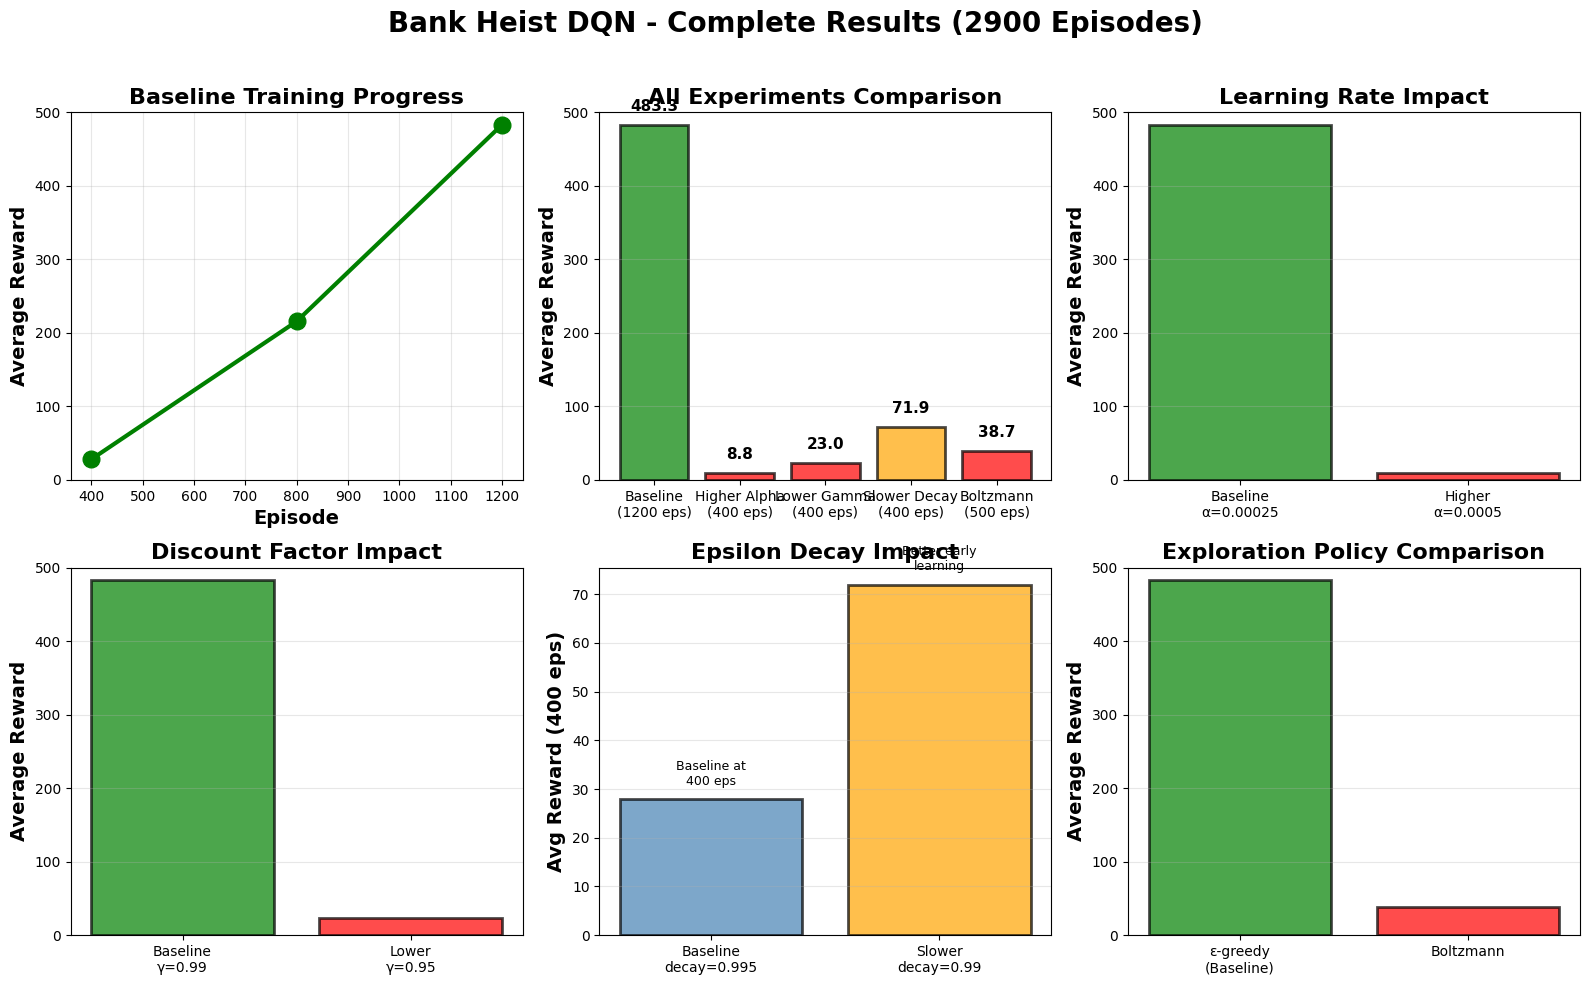

VISUALIZATION SAVED TO DRIVE!


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Your results
experiments = {
    'Baseline\n(1200 eps)': 483.3,
    'Higher Alpha\n(400 eps)': 8.8,
    'Lower Gamma\n(400 eps)': 23.0,
    'Slower Decay\n(400 eps)': 71.9,
    'Boltzmann\n(500 eps)': 38.7
}

baseline_progress = [27.9, 215.7, 483.3]
episodes = [400, 800, 1200]

# Create figure
fig = plt.figure(figsize=(16, 10))

# Plot 1: Training Progress
ax1 = plt.subplot(2, 3, 1)
ax1.plot(episodes, baseline_progress, 'o-', linewidth=3, markersize=12, color='green')
ax1.set_xlabel('Episode', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Reward', fontsize=14, fontweight='bold')
ax1.set_title('Baseline Training Progress', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 500])

# Plot 2: All Experiments
ax2 = plt.subplot(2, 3, 2)
names = list(experiments.keys())
values = list(experiments.values())
colors = ['green', 'red', 'red', 'orange', 'red']
bars = ax2.bar(names, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Average Reward', fontsize=14, fontweight='bold')
ax2.set_title('All Experiments Comparison', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', rotation=0, labelsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 500])
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 15,
            f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: Alpha Impact
ax3 = plt.subplot(2, 3, 3)
ax3.bar(['Baseline\nα=0.00025', 'Higher\nα=0.0005'], [483.3, 8.8],
        color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Average Reward', fontsize=14, fontweight='bold')
ax3.set_title('Learning Rate Impact', fontsize=16, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 500])

# Plot 4: Gamma Impact
ax4 = plt.subplot(2, 3, 4)
ax4.bar(['Baseline\nγ=0.99', 'Lower\nγ=0.95'], [483.3, 23.0],
        color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Average Reward', fontsize=14, fontweight='bold')
ax4.set_title('Discount Factor Impact', fontsize=16, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0, 500])

# Plot 5: Epsilon Decay
ax5 = plt.subplot(2, 3, 5)
ax5.bar(['Baseline\ndecay=0.995', 'Slower\ndecay=0.99'], [27.9, 71.9],
        color=['steelblue', 'orange'], alpha=0.7, edgecolor='black', linewidth=2)
ax5.set_ylabel('Avg Reward (400 eps)', fontsize=14, fontweight='bold')
ax5.set_title('Epsilon Decay Impact', fontsize=16, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
ax5.text(0, 27.9+3, 'Baseline at\n400 eps', ha='center', fontsize=9)
ax5.text(1, 71.9+3, 'Better early\nlearning', ha='center', fontsize=9)

# Plot 6: Policy Comparison
ax6 = plt.subplot(2, 3, 6)
ax6.bar(['ε-greedy\n(Baseline)', 'Boltzmann'], [483.3, 38.7],
        color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
ax6.set_ylabel('Average Reward', fontsize=14, fontweight='bold')
ax6.set_title('Exploration Policy Comparison', fontsize=16, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim([0, 500])

plt.suptitle('Bank Heist DQN - Complete Results (2900 Episodes)',
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('/content/drive/MyDrive/BankHeist_Final_Results.png', dpi=300, bbox_inches='tight')
plt.show()

print("VISUALIZATION SAVED TO DRIVE!")